In [16]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
import scipy.sparse.csgraph


## Mathmatic Functions

In [17]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean) 
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

def obj_polarization_1(A, L, op, n):
    z = np.dot(A, op) 
    z_mean = mean_center(z, n)
    #print(z.mean)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]


def mean_center_1(op, n):
    # 'op' is expected to be a 2D array with shape (1, n)
    # Calculate the mean of each column
    mean_op = np.mean(op, axis=1)  # Calculate mean along rows, producing a 1D array
    #print('mean_op',mean_op)
    # Subtract the mean from each element in the original array
    x = op - mean_op
    return x

def stub_por(s, G, A,v1,v2,n):
    #     L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    #     A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    s12 = np.array([s[v1], s[v2]])
    # print(s12)
    # Delete column v1,v2 from matrix A (correcting the deletion to a column, not a row)
    A1 = np.delete(A, [v1,v2], axis=1) # Ensure the axis is 1 to delete a column
    A2 = np.delete(A1,[v1,v2],axis=0)
    # print('A2 shape',A2.shape)
    s1 = np.delete(s,[v1,v2])
    # print('s1 shape',s1.shape)
    # Create a new array s12 containing innate opinion at indices v1 and v2
    # print(A2[[v1,v2],:].shape)
    # print(s12.shape)
    G1 = np.delete(G,[v1,v2], axis=1)
    #     print(G1.shape)
    # print('__')
    # print(np.transpose(s12).shape)
    #     print(G1[[v1,v2],:].shape)
    constant = np.dot(np.transpose(s12),G1[[v1,v2],:])  #shape 1x (n-2)
    #     print('cc shape ',c.shape)
    s1 = s1.reshape(1,(n-2))
    aa=s1+constant
    z = np.dot(aa,A2)

    z_2d = z.reshape(1, -1)
    s12_2d = s12.reshape(1, -1)
    # print(z_2d.shape)
    # print(s12_2d.shape)
    # print(z_2d)
    # #merged_array = np.concatenate((s12_2d, z_2d))
    #z_all = np.concatenate((s12_2d, z_2d), axis=1)
    #z_all = np.concatenate(z_2d)
    z_all = z_2d[0]
    #print(z_all)
    z_mean = mean_center(z_all, (n-2))
    return (np.dot(np.transpose(z_mean), z_mean)[0,0])


## Creating Network
### 1. Make Random Network

In [18]:
# name = "Karate"
# filename = "%s.ipynb" % name
# print(filename)
# %run filename
#%run Sythetic.ipynb
%run Karate.ipynb
#%run Twitter.ipynb
#%run Reddit.ipynb
np.set_printoptions(precision=5)

There are 34 agents
[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [19]:
v1 = 1
C1I = G[v1]
print(C1I)

[1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [26]:
# # Import network
# ZKC_graph = nx.karate_club_graph()
# G = nx.convert_matrix.to_numpy_array(ZKC_graph)

## Add rescaling parameter to the Adjacency Matrix G, this way the column sum and row sum can be smaller than 1 - required in CB
def rescale_adjacency_matrix(G1):
    # Calculate the row sums and column sums
    row_sums = np.sum(G1, axis=1)
    col_sums = np.sum(G1, axis=0)
    
    # Determine the maximum row sum and column sum
    max_row_sum = np.max(row_sums)
    max_col_sum = np.max(col_sums)
    
    # Determine the scaling factor
    scaling_factor = 1 / (max(max_row_sum, max_col_sum)+1) #+1 in the denominator will give row&column sum result less than 1
    
    # Rescale the adjacency matrix
    G_rescaled = G1 * scaling_factor
    
    return G_rescaled

def create_par(G_rescaled):
    G_resclaed = rescale_adjacency_matrix(G)
    # print(G_resclaed)
    row_sums = np.sum(G_rescaled, axis=1)
    # print(row_sums)
    col_sums = np.sum(G_rescaled, axis=0)
    # print(col_sums)
    max_col = np.max(col_sums)
    max_row = np.max(row_sums)
    # print(max_col,max_row)
    # print(max(max_col,max_row))
    par = 1-max(max_col,max_row)
    (beta, gamma) = (par/200, par/400)
    # print(beta, gamma)
    return (beta, gamma)

def cal_par(v1,v2,G):
# remove info source connection from the adjacency matrix
    G_int = np.delete(G,[v1,v2], axis=1)
    G1 = np.delete(G_int,[v1,v2], axis=0)
    G_rescaled = rescale_adjacency_matrix(G1)
    (beta, gamma) = create_par(G_rescaled)
    
    return (beta, gamma)

In [27]:
v1=0
v2=1
c1i = np.delete(G[v1],[v1,v2], axis =0)
print(len(c1i))

32


In [28]:
#     ##calculate equlibriua manually (Successful!!!)
def equilibrium(v1,v2, n1,s,g,h,G,beta,gamma): 
    ## Cki are the determinate parameter indicate if info. source influence the agent or not
    c1i = np.delete(G[v1],[v1,v2], axis =0)
    c2i = np.delete(G[v2],[v1,v2], axis =0)
    # c1i = [1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
    # c2i = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    C1 = np.diag(c1i, k=0)
    C2 = np.diag(c2i, k=0)
    
    # exclude info source opinion
    opinion = np.delete(s,[v1,v2]) 
    R1 = C1*opinion
    R2 = C2*opinion
    I = np.eye(n1)

    G_int = np.delete(G,[v1,v2], axis=1)
    G1 = np.delete(G_int,[v1,v2], axis=0)

    Ematrix = I - G1 + gamma*(R2 - R1 + h*C1 - g*C2)
    Ematrix_inverse = np.linalg.inv(Ematrix)
    rowsum = np.sum(G1,1)
    rowsumm_atrix = np.zeros((n1, n1))
    for i in range(n1):
        rowsumm_atrix[i,i] = rowsum[i]
    addMatrix = I - rowsumm_atrix - (C1+C2)*beta + (C1*h + C2*g)*gamma
    A = np.matmul(Ematrix_inverse,addMatrix)
    Vector_A = (c1i*h + c2i*g)*beta + (c2i*g**2-c1i*h**2)*gamma
    # print(np.shape(Vector_A))
    trans_Vector_A = Vector_A.transpose()
    # print(np.shape(trans_Vector_A))
    L = np.matmul(Ematrix_inverse, trans_Vector_A)
    # print(L)
    z1 = np.matmul(A,opinion) + L
    
    print("equilibrium opinion")
    print(z1)
    return (z1)

In [ ]:
##calculate equlibriua manually (Successful!!!)
rowsumm_atrix = np.zeros((nrows, ncols))
for i in range(nrows):
    rowsumm_atrix[i,i] = rowsum[i]
Ematrix = np.eye(nrows) - adjacency + (g-h)*gamma*(np.eye(nrows))
Ematrix_inverse = np.linalg.inv(Ematrix)
addMatrix = np.eye(nrows) - rowsumm_atrix - 2*beta*(np.eye(nrows)) + (h-g)*gamma*(np.eye(nrows))
Matrix_A = np.matmul(Ematrix_inverse,addMatrix)
Vector_A = (h+g)*beta*(np.ones((nrows,1))) + ((g**2)-(h**2))*gamma*(np.ones((nrows,1)))
equilibriua = np.matmul(Matrix_A,np.transpose([innate])) + np.matmul(Ematrix_inverse,Vector_A)

In [29]:
def z_mean(G,s):
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    z = np.dot(A, s) 
    z_mean = np.mean(z) 
    return z_mean

In [30]:
def make_payoff_row(s,v2, G, n1, g):
    payoff_row = np.zeros(2*n)
    for column in range(2*n):
#         print(column)
        v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
        if v1==v2:
            pass
        else:
            # update the maximizer's info opinion "h" that regarding minimizer(op1)
            h = 1 
            # update beta gamma value based on different Info Source location
            (beta, gamma) = cal_par(v1,v2,G)
            
            z1 = equilibrium(v1,v2, n1,s,g,h,G,beta,gamma)
         # calculate the mean steady-state opinion with both max and min's action
            payoff_row[column] = np.mean(z1, axis=0) #stub_por(op2, G, A,v1,v2,n) 

        j_1 = 2*v2 + 0
        j_2 = 2*v2 + 1
       # O_P = obj_polarization_1(A, L, s, n)#obj_innate_polarization(s, n)
        payoff_row[j_1] = z_mean(G,s)#O_P  --------------------------------need change
        payoff_row[j_2] = z_mean(G,s)#O_P  --------------------------------need change what is cancel out result???
    
    return payoff_row

def make_payoff_matrix(s,n,G):
    payoff_matrix = np.empty((0, 2*n), float)
    C1 = list(range(n))    # for all agent 
    n1 = n-2
    for v2 in C1:         
            print('Minimizer start from agent'+str(v2))
            # min_opi_option = np.arange(0,1.01,0.01) 
            #Update Min's info source's opinion
            g = 0
    # update min info source opinion to decide max info source op:
             # op = copy.copy(s)
             # op[v2] = min_op
            payoff_row = make_payoff_row(s,v2, G, n1, g)
            # print(payoff_row)
            payoff_matrix = np.vstack([payoff_matrix, payoff_row])
    return payoff_matrix

In [31]:
payoff_matrix = make_payoff_matrix(s,n,G)
#pd.DataFrame(payoff_matrix).to_csv('Karate Stubborn Discrete Payoff Matrix_05052024.csv')
#pd.DataFrame(payoff_matrix).to_csv('Karate Payoff Matrix CB with 2 info source.csv')
#pd.DataFrame(payoff_matrix).to_csv('Twitter Discrete Payoff Matrix1.csv')



Minimizer start from agent0
equilibrium opinion
[ 3.55945 -2.59913  1.092    0.43054  0.40831  0.22235  6.42469  0.09127
  1.0849   0.77011 -2.59908 -3.01782 -1.09855 -0.75737  0.32681  0.75472
 -0.68638 -3.17477 -0.5724   0.55904 -0.59092  4.57439  1.41741  1.20001
 -4.46646  5.63873 -4.24225 -0.84636  5.32096 -3.94627  2.84063 -3.17519]
equilibrium opinion
[ 3.55945 -2.59913  1.092    0.43054  0.40831  0.22235  6.42469  0.09127
  1.0849   0.77011 -2.59908 -3.01782 -1.09855 -0.75737  0.32681  0.75472
 -0.68638 -3.17477 -0.5724   0.55904 -0.59092  4.57439  1.41741  1.20001
 -4.46646  5.63873 -4.24225 -0.84636  5.32096 -3.94627  2.84063 -3.17519]
equilibrium opinion
[ 1.71098 -0.37463  1.092    0.43054  0.40831  0.59833  3.73333 -2.07772
  1.0849   0.77011 -0.37477 -1.54482 -0.33577  0.00541  0.32681  1.71059
  0.0764  -0.73283  0.19038  1.7107   0.17186  2.71443  1.58466  2.39192
 -3.27465  1.72945 -3.47938 -0.75173  4.71935 -1.06165  2.50623 -2.07802]
equilibrium opinion
[ 1.71098 -0.

34


<Figure size 2000x2000 with 0 Axes>

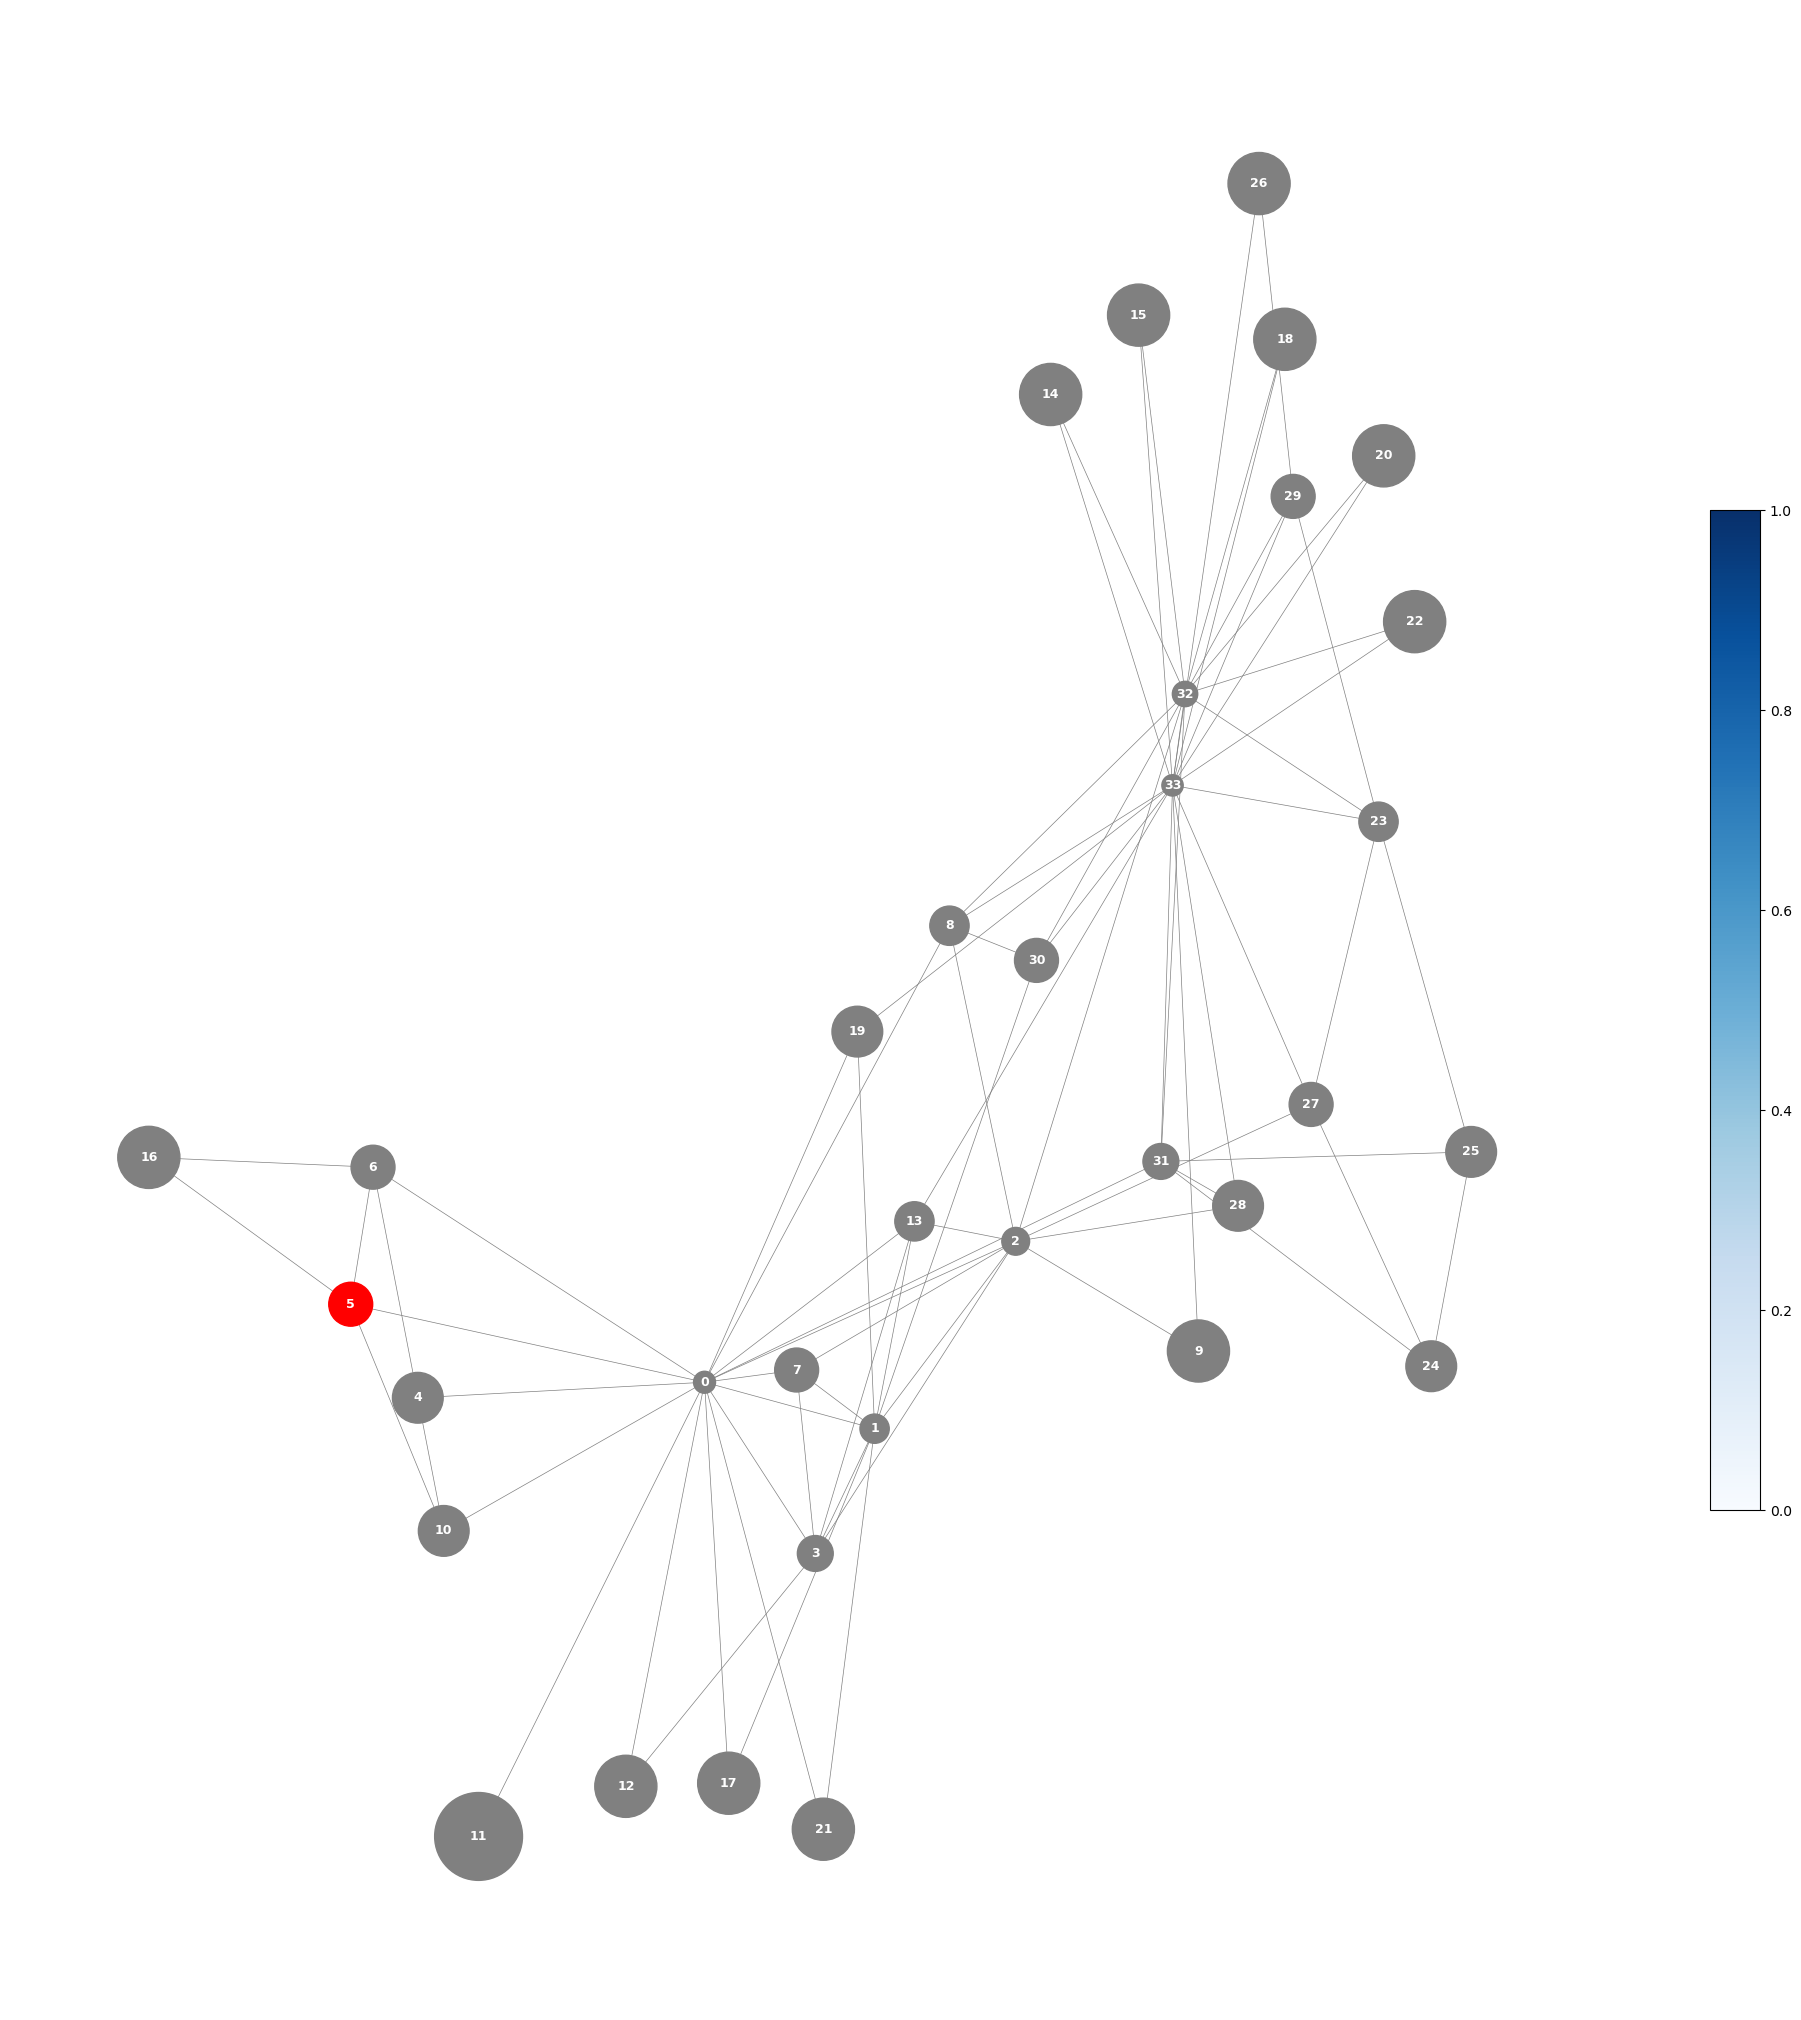

In [7]:
# what the twitter graph looks like 
s_use = s.flatten()   # Convert array to a list for later operation
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2

nxG = nx.from_numpy_array(G)   
# nxG = nx.relabel_nodes(nxG, mapping)      
plt.figure(figsize=(20, 20))


def node_edge(G, n):
    edges =[]
    for v in range(n):
        a = np.array(np.nonzero(G[v])[0])
        edge = len(a)
#         print(edge)
        edges.append(edge)
        
    return edges

node_edges = node_edge(G, n)
# print(node_edges)

node_sizes =[]
for i in node_edges:
    node_size = 1/i*4000
    node_sizes.append(node_size)

#min_equi = [48]
# max_equi = [156,266,363]

# Reddit Stubborn Game
min_equi = [48,]
max_equi = [5,51,54,64]

# Twitter stubborn Game
# min_equi = [48]
# max_equi = [481]


# Create node color
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('red')
    else:
        color_map.append('grey')
# print(node_sizes)

######################### Calculate Key Values & Visualization #######################################3
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n   
m = num_edges(L, n)                    # call the function to calculate the number of edges
columnsum_ij = np.sum(A, axis=0)
#print(columnsum_ij)
print(n)
# what the twitter graph looks like 
nxG = nx.from_numpy_array(G)          
plt.figure(figsize=(20, 20))

# Fix seed - fix network shape
my_pos = nx.spring_layout(nxG, seed = 2)
#nx.draw(nxG, pos= my_pos, with_labels= False, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
nx.draw(nxG, pos = my_pos, with_labels=True, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, shrink = 0.5)
tick_font_size = 24
#cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()

# if we want to customize the color bar range to min/max s
# vmin = min(s)
# vmax = max(s)
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.5)
# plt.show()

### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [9]:
v1=0
v2=1
print('Innate polarization:')
print(obj_innate_polarization(s, n))
# Calculate innate polarization
print('Equi. polarization')
print(obj_polarization_1(A, L, s, n))
print('stubborn polarization')
print(stub_por(s, G,A,v1,v2,n))
#print(stub_por(s, A,v1,v2,n))
# agent = 48
# network_anl(s,n,G,agent)


Innate polarization:
1.1743186020487546
Equi. polarization
0.15967526924290515
stubborn polarization
0.2730144576643247


IndexError: index 48 is out of bounds for axis 0 with size 34

In [31]:
print(payoff_matrix)

NameError: name 'payoff_matrix' is not defined

### Testing players' behavior

In [ ]:
def MinMax_play(s,n):    # maxmizer first-time play, greedy algorithm
    print('Minimizer Play')
   
    (v1, min_opinion, min_pol, max_action) = choose_min_vertex(s, n) # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    (v2, max_opinion) = max_action
    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        #Store innate_op of the max_selected vertex
        old_opinion_min = s[v1, 0]
        old_opinion_max = s[v2, 0]
        ##### change the agent's opinion with best action(agent v1, max_op)

        ## check if agent's opinionis is changed or not
        print("Max Action:    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
        print("Min Action:    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
        print("Network reaches equilibrium Polarization: " + str(min_pol))


    return(v1, min_opinion, min_pol)

In [ ]:
# determine which agent maximizer should select to maximizer the equilibrium polarization
def choose_min_vertex(s, n):
   # max_por = obj_polarization(A, L, op, n)  # use "innate"(after min action) polarization as a comparable standard to find max_por
    min_por = 10000
    C1 = list(range(n))    # for all agent 
    for v1 in C1:         
            print('Minimizer start from agent'+str(v1))
            print("__________________________________")
            (min_opinion, por, max_action) = get_min_opinion(s, n, v1)
 
            if por < min_por: # if the polarization of most recent action > maximum polarization of previous actions
                min_por = por
                champion = (v1, min_opinion,min_por, max_action)   # save the this action as champion    
    print("Min champion", champion)
    return (champion)


In [ ]:
def find_search_center(por_arr, ith):
    mylist = sorted(por_arr)
    Snd_por = mylist[ith-1]

    search_center = por_arr.index(Snd_por)
    return (search_center)
# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def get_min_opinion(s, n, v1):
    
    por_arr = [] #np.zeros(11)  # create a two_element array to store polarization value of each option
    #min_opi_option = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] #Min has 10 options to change agent v2's opinion
    min_opi_option = np.arange(0,1.05,0.05)
    min_pol = 1000 # set a big standarlization
    CK_RANK = 2
    t = 0
    min_por = 1000
    max_champion = (None, None)
    while t<5:

        t +=1
#         print(str(t)+"_________________________________")
#         print("min_opi_option:",min_opi_option)
        por_arr = [] #np.zeros(11)  # create a two_element array to store polarization value of each option

        for min_opinion in min_opi_option:
#             print(v1,min_opinion)
            (v2,max_opinion, pol) = minmax_polar(s,v1,min_opinion)
            por_arr.append(pol)
            #print("max_pol: ", max_pol)
            if  pol < min_por:
                min_por = pol
                max_champion = (v2,max_opinion)
                min_op = min_opinion
                print(max_champion)
            minimize_por = min(por_arr)
            minmize_op = min_opi_option[np.argmin(por_arr)]  # the index of maximum polarization = max_opinion --[0,1]

#         print("Max_champion:",max_champion)   
#         print("Min choice:", por_arr)
        
        if t == 1:
            Original_min_por = minimize_por
            ith = CK_RANK # after finding the min discret min_op, search near to the 2nd min_op
        elif t>1:
            ith = 1  #search minimum near to the ith min por
#             if Original_min_por<= minimize_por:        
#     #             print("Original_min_por,min_por,:", )
#                 print("1st discrete min is Optimal:", Original_min_por, min_por)#, Origin, min_por:", Original_min_por, min_por)
#             else:   
#                 print("1st discrete min NOT optimal, Original_min_por,min_por:",Original_min_por, min_por)
        search_center = find_search_center(por_arr, ith)
        low_op = min_opi_option[min(abs(search_center-1),search_center)] #Avoid if 2nd minimum at the edge
        up_op = min_opi_option[min(search_center+1, len(por_arr)-1)] 
#         print("SERACH BOUND:",low_op,up_op)
        min_opi_option = np.linspace(low_op,up_op,10)        
        continue 
        
    print("Max_champion:",max_champion)
    print("Min_champion:", (v1, min_op))
    
    return (min_op, min_por, max_champion)

In [ ]:
def minmax_polar(s, v1, min_opinion):
    op = copy.copy(s)
    op[v1] = min_opinion  
    (v2,max_opinion, max_pol) = maximizer_play(op,n,v1)
    
    return (v2,max_opinion, max_pol)
    
    

In [ ]:
##### minimizer first-time play, greedy algorithm
def maximizer_play(op,n,min_touched): 
    
    op1 = copy.copy(op)
    max_champion = choose_max_vertex(op1, n, min_touched) 
    (v2, max_opinion, max_pol) = max_champion
    
    if v2 == None:
        print('Minimizer fail')

    return (v2,max_opinion, max_pol)

### Minimizer Strategy

In [ ]:
# Minimizer search: Go through each agent 

def choose_max_vertex(op, n, min_touched):
    # current opinion array that changed by maximizer, "innate" opinion that min start with

    #champion = (None, None, 0, None)  # assume the best action is champion
    max_por = 0
    all = list(range(n))    # for all agent 
    C1 = [x for x in all]  # for the vertice that Maximizer has not touched
    
    for v2 in C1:   
        #print('Max start with agent '+ str(v2) )
        if v2 == min_touched:
            changed_opinion = None
            innate_por = obj_innate_polarization(s, n)
            champion = (v2, changed_opinion, innate_por)
        
        else:
            (changed_opinion, por) = get_max_opinion(op,n,v2)   # find the best new_op option           

            if por > max_por:  # if the recent polarization is smaller than the minimum polarization in the history
                max_por = por                         # update the recent option as champion
                champion = (v2, changed_opinion, max_por)  
#     print("Max champion", champion)
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [ ]:
# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def get_max_opinion(op, n, v2):
    
    por_arr = np.zeros(2)  # create a two_element array to store polarization value of each option
    max_opi_option = [0, 1.0]   # Maximizer has two options to change agent v1's opinion
    op1 = copy.copy(op)
    
    # objective if set opinion to 0, 1.0
    j = 0
    for max_opinion in max_opi_option:
        op1[v2] = max_opinion
#         print("max change opinion:",op1)
        max_pol = obj_polarization(A, L, op1, n)
        por_arr[j] = max_pol
        j = j + 1   # index increase 1, put the polarization in array

    maxmize_op = np.argmax(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
    max_por = np.max(por_arr)        # find the maximum polarization in the record
    
    return (maxmize_op, max_por)

In [ ]:
MinMax_play(s,n)

In [ ]:
agent = 6
network_anl(s,n,G,agent)

# 5. Innate Op and Game

## 5A. Payoff Matrix - op dynamic

In [ ]:
### Save simulation result to TXT file

# with open('Result'+str(Network)+'.'+str(Experiment)+'.txt', "a") as f:
# #     print(Experiment_note, file=f)
#     print('Initial Condition -(agent, opinion, pol)', file=f)
#     print('Innate op'+str(s),file=f)
#     print('Adjacency matrix'+ str(G), file=f)
np.arange(0,1.01,0.01)

## 5B. Payoff Matrix - No Op Dynamic 

In [ ]:
def make_payoff_row_noopdy(op1,v2, A, L, n):
    payoff_row = np.zeros(2*n)

    for column in range(2*n):
#         print(column)
        v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
        max_opinion = column%2
#         print(v1, max_opinion)
        # update the maximizer's change to the opinion array that has changed by minimizer(op1)
        op2 = copy.copy(op1)
        op2[v1,0] = max_opinion
        # calculate the polarization with both max and min's action
        payoff_row[column] = obj_innate_polarization(op2, n) 
    
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    O_P = obj_innate_polarization(s, n)
    payoff_row[j_1] = O_P
    payoff_row[j_2] = O_P
    
    return payoff_row

def make_payoff_matrix_noopdy(s,n):
    payoff_matrix = np.empty((0, 2*n), float)
    C1 = list(range(n))    # for all agent 
    for v2 in C1:         
            print('Minimizer start from agent'+str(v2))
            min_opi_option = np.arange(0,1.01,0.01) #Min has two options to change agent v2's opinion
            for min_op in min_opi_option:
                     op = copy.copy(s)
                     op[v2] = min_op
                     payoff_row = make_payoff_row_noopdy(op,v2, A, L, n) 
#                      print(payoff_row)
                     payoff_matrix = np.vstack([payoff_matrix, payoff_row])
    return payoff_matrix

In [ ]:
payoff_matrix = make_payoff_matrix_noopdy(s,n)
#pd.DataFrame(payoff_matrix).to_csv('Karate NoOpDyn Discrete Payoff Matrix1.csv')
#pd.DataFrame(payoff_matrix).to_csv('Reddit NoOpDyn Discrete Payoff Matrix1.csv')
#pd.DataFrame(payoff_matrix).to_csv('Twitter NoOpDyn Discrete Payoff Matrix1.csv')

